In [1]:
#모듈 import 한글폰트 적용
from bs4 import BeautifulSoup
import urllib.request as req
import matplotlib as mpl
import matplotlib.font_manager as fm
import matplotlib.pylab as plt
import pandas as pd
import datetime, re, time

mpl.rcParams['axes.unicode_minus']=False
font_l=fm.findSystemFonts(fontpaths=None,fontext='ttf')
f=[f.name for f in fm.fontManager.ttflist]
[(f.name,f.fname) for f in fm.fontManager.ttflist if 'Nanum' in f.name]
path = 'C:\\WINDOWS\\Fonts\\\x7f\x7f\x7f\x7fBOLD.TTF'
font_name = fm.FontProperties(fname=path, size=50).get_name()
print(font_name)
plt.rc('font', family=font_name)

NanumGothic


In [44]:
movie_list=[]

In [45]:
now=datetime.datetime.now()
now=now.strftime("%Y%m%d")
found_list=[]
name_list=[]
#중복검색피하기
def checkTime(func):
    def newFunc():
        start=time.time()
        func()
        end=time.time()
        print("\n실행시간: ", end-start)
    return newFunc

@checkTime
def main():
    try:
        movieProgram()
    except searchError as e:
        print(e.args[0])
    except ValueError:
        print("숫자를 입력하세요")
#영화정보에 대한 클래스
class movieInfo():
    def __init__(self,name,genre,country,actor,wgrade,release,mark):
        self._name=name
        self._country=country
        self._wgrade=wgrade
        self._genre=genre
        self._actor=actor
        self._release=release
        self._mark=mark
    @property
    def name(self):
        return self._name
    @property
    def genre(self):
        return self._genre
    @property
    def country(self):
        return self._country
    @property
    def actor(self):
        return self._actor
    @property
    def wgrade(self):
        return self._wgrade
    @wgrade.setter
    def wgrade(self,value):
        self._wgrade=value
    @property
    def release(self):
        return self._release
    @property
    def mark(self):
        return self._mark
#에러처리
class searchError(Exception):
    def __init__(self,msg):
        self._msg=msg

def movieProgram():
#     movie_list=[]
    t=int(input("영화 정보 검색 시스템입니다. \n검색 기간을 정하세요.\n오늘: 0     한달: 1     "))
    if t==1:
        s_day,e_day=getDay()
        for i in range(s_day,e_day):
            i=str(i)
            url_t="https://movie.naver.com/movie/sdb/rank/rmovie.nhn?sel=cnt&date="+i
            #평점순(전체영화)에 대한 검색
            movieScraping(url_t,movie_list)
            print("{}일 완료".format(i))
        print("스크래핑을 완료했습니다.")
    elif t==0:
        c=int(input("\n기준을 정하세요\n조회순: 1     평점순(현재상영영화): 2     평점순(전체영화): 3    "))
        if c==1: 
            url_t="https://movie.naver.com/movie/sdb/rank/rmovie.nhn"
        elif c==2:
            url_t="https://movie.naver.com/movie/sdb/rank/rmovie.nhn?sel=cur&date="+now
        elif c==3:
            url_t="https://movie.naver.com/movie/sdb/rank/rmovie.nhn?sel=pnt&date="+now
        else:
            raise searchError("올바른 기준 숫자를 입력하세요.")
            return
        movieScraping(url_t,movie_list)
        findMovie(movie_list,found_list)
    else:
        raise searchError("올바른 검색기간 숫자를 입력하세요.")
        return
    
def movieScraping(url_t,movie_list):
    url="https://movie.naver.com/movie/sdb/rank/rmovie.nhn"
    
    res=req.urlopen(url_t)
    soup=BeautifulSoup(res,"html.parser")
    
    url_list=[]
    href_list=soup.select("#old_content > table > tbody > tr > td.title a")

    for i in href_list:
        i=str(i)
        m_url,m_name=getUrl(i)
        if m_name in name_list:
            continue
        else:
            url_list.append(m_url)
            name_list.append(m_name)

    for i,j in enumerate(url_list):
        temp_url=url+j
        res_m=req.urlopen(temp_url)
        soup_m=BeautifulSoup(res_m,"html.parser")
        a_list=soup_m.select("#container > #content > div.article > div.mv_info_area > div.mv_info > dl a")
        b_list=soup_m.select("#content > div.article > div.mv_info_area > div.mv_info > div.main_score > div > a > div > span > span")
        #b는 관람객 평점용
        t_actor=""
        t_genre=""
        t_coun=""
        t_grade="알수없음"
        t_release=0
        t_mark=0.0
        for k in a_list:
            k=str(k)
            a=getInfo(k)
            if(a):
                if a[1]==1:
                    t_genre+=" "+a[0]
                elif a[1]==2:
                    t_coun=a[0]
                elif a[1]==3:
                    t_actor+=" "+a[0]
                elif a[1]==4:
                    if "관람" in a[0]:
                        t_grade=a[0]
                    elif t_grade=="알수없음" and len(a[0])>0:
                        t_grade=a[0]
                elif a[1]==5:
                    t_release=int(a[0])
        for k in b_list:
            k=str(k)
            a=getInfo(k)
            t_mark=a[0]
        t_actor=t_actor.strip()
        movie=movieInfo(name_list[i],t_genre,t_coun,t_actor,t_grade,t_release,t_mark)
        movie_list.append(movie)

def getDay():
    now=datetime.datetime.now()
    now=now.strftime("%Y%m")
    ym=input("조사할 년월을 입력하세요(ex)201905: ")
    if len(ym)!=6:
        raise searchError("조건에 맞는 숫자를 입력하세요.")
    elif int(ym)>int(now):
        raise searchError("미래 정보는 검색할 수 없습니다.")
    yms=int(ym+'01')
    if ym==now:
        yme=int(now.strftime("%Y%m%d"))
    else:
        y_t=int(ym[0:4])
        m_t=int(ym[4:])
        if (m_t%2==1 and m_t<8) or (m_t%2==0 and m_t>7):
            yme=int(ym+'31')
        elif m_t==2:
            if y_t%400==0:
                yme=int(ym+'29')
            elif y_t%100==0:
                yme=int(ym+'28')
            elif y_t%4==0:
                yme=int(ym+'29')
            else:
                yme=int(ym+'28')
        else:
            yme=int(ym+'30')
    yme+=1
    return yms,yme

def getUrl(Info):
    p=re.compile(r'["](.*?)["].*["](.*?)["]')
    m=p.search(Info)
    url=m.group(1)
    name=m.group(2)
    return url,name

def getInfo(Info):
    flag=0
    p=re.compile(r'(?<=>)(.*)(?=<)')
    po=re.compile(r'\d+')
    pm=re.compile(r'(?<=>).*\s(\d+[.]\d+).*(?=<)')
    pg=re.compile(r'(?<=>)(.*)(?=<)')
    if 'genre' in Info:
        m=p.search(Info)
        flag=1
    elif 'nation' in Info:
        m=p.search(Info)
        flag=2
    elif 'code' in Info:
        m=p.search(Info)
        flag=3
    elif 'grade' in Info:
        m=p.search(Info)
        flag=4
    elif 'open' in Info:
        m=po.search(Info)
        flag=5
    elif '관람객 평점' in Info:
        m=pm.search(Info)
        flag=6
        if(m==None):
            return [11.0,flag]
        else:
            return [float(m.group(1)),flag]
    else:
        return
    if m.group()=='더보기':
        return
    return [m.group(),flag]

def findMovie(movie_list,found_list):
    flag=1
    n=int(input("\n이름: 0     장르: 1     국가: 2     배우: 3     등급: 4     개봉년도(이상): 5     개봉년도(이하): 6\
     평점: 7\n\n찾고 싶은 정보에 대한 숫자를 입력하시오: "))
    if n==0:
        m_name=input("\n영화이름: ")
        for i in movie_list:
            if i.name==m_name:
                printSave(i)
                found_list.append(i)
                return found_list
    elif n==1:
        m_genre=input("\n원하는 장르: ")
        for i in movie_list:
            if m_genre in i.genre:
                printSave(i)
                found_list.append(i)
                flag=0
    elif n==2:
        m_country=input("\n원하는 제작 국가: ")
        for i in movie_list:
            if m_country in i.country:
                printSave(i)
                found_list.append(i)
                flag=0
    elif n==3:
        m_actor=input("\n원하는 배우: ")
        for i in movie_list:
            if m_actor in i.actor:
                printSave(i)
                found_list.append(i)
                flag=0
    elif n==4:
        m_wgrade=input("\n시청 등급(나이)(전체, 12, 15, 관람불가): ")
        for i in movie_list:
            if m_wgrade in i.wgrade:
                printSave(i)
                found_list.append(i)
                flag=0
    elif n==5:
        m_open=int(input("\n원하는 개봉년도(이상)(8자리): "))
        if m_open>int(now):
            raise searchError("\n올바른 개봉 년월일을 입력하세요")
            return
        for i in movie_list:
            if m_open<=i.release:
                printSave(i)
                found_list.append(i)
                flag=0
    elif n==6:
        m_open=int(input("\n원하는 개봉년도(이하)(8자리): "))
        for i in movie_list:
            if m_open>=i.release:
                printSave(i)
                found_list.append(i)
                flag=0
    elif n==7:
        m_mark=float(input("\n원하는 평점(이상)(0.0~10.0): "))
        if m_mark<0 or m_mark>10:
            raise searchError("\n알맞은 평점을 입력하세요")
            return
        else:
            for i in movie_list:
                if i.mark>=m_mark:
                    printSave(i)
                    found_list.append(i)
                    flag=0
    else:
        raise searchError("\n알맞은 검색 숫자를 입력하세요.")
    if flag:
        print("\n해당하는 영화 정보가 없습니다.")
        return

def printSave(mvobj):
    print("\n")
    print("영화이름:  ", mvobj.name)
    print("장르:      ",mvobj.genre)
    print("국가:      ",mvobj.country)
    print("감독,배우: ",mvobj.actor)
    print("시청 등급: ", mvobj.wgrade)
    print("개봉일시:  ", mvobj.release)
    if mvobj.mark==11:
        print("관람객평점 없음")
    else:
        print("관람객평점: ", mvobj.mark)
        
main()

영화 정보 검색 시스템입니다. 
검색 기간을 정하세요.
오늘: 0     한달: 1     1
조사할 년월을 입력하세요(ex)201905: 201811
20181101일 완료
20181102일 완료
20181103일 완료
20181104일 완료
20181105일 완료
20181106일 완료
20181107일 완료
20181108일 완료
20181109일 완료
20181110일 완료
20181111일 완료
20181112일 완료
20181113일 완료
20181114일 완료
20181115일 완료
20181116일 완료
20181117일 완료
20181118일 완료
20181119일 완료
20181120일 완료
20181121일 완료
20181122일 완료
20181123일 완료
20181124일 완료
20181125일 완료
20181126일 완료
20181127일 완료
20181128일 완료
20181129일 완료
20181130일 완료
스크래핑을 완료했습니다.

실행시간:  68.8898823261261


In [46]:
#데이터 가시화

name=[]
country={}
genre={}
wgrade={}
c_g={}
#국가(c)별 장르(g)
for i in movie_list:
    if i.name in name:
        continue
    else:
        name.append(i.name)
    genre_d={'드라마':0,'코미디':0,'액션':0,'모험':0,'가족':0, '판타지':0,\
         '멜로/로맨스':0, 'SF':0, '전쟁':0, '공포':0,'스릴러':0, '서스펜스':0,\
             '애니메이션':0, '범죄':0,'뮤지컬':0, '다큐멘터리':0,'블랙코미디':0, '미스터리':0}
    if i.country not in country:
        country[i.country]=1
        c_g[i.country]=genre_d
    else:
        country[i.country]+=1
    i_genre=i.genre.split(' ')
    del(i_genre[0])
    for j in i_genre:
        j=j.strip()
        c_g[i.country][j]+=1
        if j not in genre:
            genre[j]=1
        else:
            genre[j]+=1
    if i.wgrade not in wgrade:
        wgrade[i.wgrade]=1
    else:
        wgrade[i.wgrade]+=1
label_c=list(country.keys())
data_c=list(country.values())
label_g=list(genre.keys())
data_g=list(genre.values())
label_w=list(wgrade.keys())
data_w=list(wgrade.values())
cntry_chart=pd.DataFrame(data_c,index=label_c,columns=["개수"]).sort_values(by='개수',ascending=False)
genre_chart=pd.DataFrame(data_g,index=label_g,columns=['개수']).sort_values(by='개수',ascending=False)
wgrade_chart=pd.DataFrame(data_w,index=label_w,columns=['개수']).sort_values(by='개수',ascending=False)
cg_chart=pd.DataFrame(c_g).T
cg_chart

,SF,가족,공포,다큐멘터리,드라마,멜로/로맨스,모험,뮤지컬,미스터리,범죄,블랙코미디,서스펜스,스릴러,애니메이션,액션,전쟁,코미디,판타지
한국,0,0,2,1,12,2,0,0,2,4,0,0,1,0,5,0,4,1
영국,0,2,0,0,1,0,3,0,1,0,0,0,0,1,0,1,0,1
미국,3,1,3,0,5,3,6,0,3,1,0,0,6,1,5,0,2,3
일본,0,0,0,0,0,0,1,0,0,0,0,0,0,2,0,0,0,1
페루,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0
오스트레일리아,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1


In [55]:
genre_chart

,개수
드라마,18
모험,12
액션,10
코미디,7
스릴러,7
판타지,7
미스터리,6
범죄,5
공포,5
멜로/로맨스,5


In [ ]:
cntry_chart

In [ ]:
wgrade_chart

In [ ]:
%matplotlib nbagg

fig=plt.figure(figsize=(10,30))
ax1=fig.add_subplot(3,1,1)
ax2=fig.add_subplot(3,1,2)
ax3=fig.add_subplot(3,1,3)
ax1.pie(data_c,labels=label_c,startangle=90,autopct='%1.1f%%')
ax2.pie(data_g,labels=label_g,startangle=90,autopct='%1.1f%%')
ax3.pie(data_w,labels=label_w,startangle=90,autopct='%1.1f%%')

In [ ]:
cg_chart.plot(kind='bar',stacked=True)

In [47]:
genre_11=genre

In [41]:
genre_8=genre

In [29]:
genre_5=genre

In [23]:
genre_1=genre

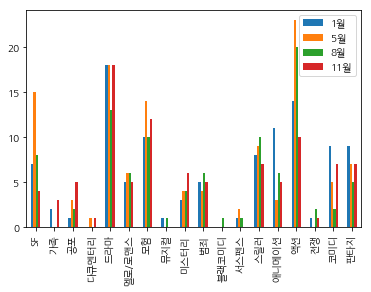

In [54]:
genre_month={"1월": genre_1,"5월": genre_5,"8월":genre_8,"11월":genre_11}
ggg=pd.DataFrame(genre_month)
ggg.plot(kind='bar', stacked=False)